# Colab Setup

In [1]:
# connect to google drive to save weights

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# utility to download data from drive to colab
# large dataset zip file is in diff. account drive,
# not in the drive where weights are saved

!git clone https://github.com/chentinghao/download_google_drive.git 

In [3]:
# download weights trained in previous session

!python download_google_drive/download_gdrive.py LINK_REMOVED_HERE model_05.pt

93.1MB [00:01, 51.4MB/s]


# Module Import

In [4]:
import os, cv2
from PIL import Image

import numpy as np
import json, shutil
import pandas as pd
from tqdm import tqdm, trange
import random, datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [5]:
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR #as MultiStepLR
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [6]:
!pip install pkbar

In [7]:
import pkbar

<b> The colab session has 15GB RAM </b>

In [8]:
!nvidia-smi

Fri Feb 12 05:29:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Kaggle Setup

In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=8c4253389e9c15810f17a9079fe5c7bd0abd1b471ea46ec0262c176f73996743
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [10]:
!mkdir ~/.kaggle 
fd=open("/root/.kaggle/kaggle.json", "w")
json_data="""{"username":"USERNAME","key":"KEY"}"""
fd.write(json_data)
fd.close()

In [11]:
!chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [12]:
!mkdir data

In [13]:
%cd /content/data/
!kaggle competitions download -c cassava-leaf-disease-classification
%cd /content

/content/data
100% 5.76G/5.76G [02:01<00:00, 34.6MB/s]
100% 5.76G/5.76G [02:01<00:00, 50.8MB/s]
/content


In [ ]:
%cd /content/data/
!unzip cassava-leaf-disease-classification.zip
%cd /content

# Data Analysis

In [15]:
inp_dir="/content/data"
os.listdir(inp_dir)

['train_tfrecords',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'cassava-leaf-disease-classification.zip',
 'train.csv',
 'train_images',
 'test_images',
 'test_tfrecords']

<b> get class mapping from json file </b>

In [17]:
fd=open('/content/data/label_num_to_disease_map.json')
data=json.load(fd)
fd.close()
data

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

<b> per image label </b>

In [18]:
csv_path=os.path.join(inp_dir, "train.csv")
df=pd.read_csv(csv_path)

df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<b> train/test split of data </b>

In [19]:
N=df.shape[0]
N1=int(N*0.8)

df1=df.iloc[:N1, :]
df2=df.iloc[N1:, :]

df2.reset_index(inplace=True)
df2 = df2.drop('index', 1)

df1.shape, df2.shape, df1.shape[0]+df2.shape[0]

((17117, 2), (4280, 2), 21397)

<b> train data dataframe</b>

In [20]:
df1.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<b> test data dataframe</b>

In [21]:
df2.head()

,image_id,label
0,4081152393.jpg,3
1,4081341161.jpg,1
2,408144068.jpg,3
3,4081836555.jpg,3
4,4082024517.jpg,3


In [22]:
# total images, train images, test images
N,N1,N-N1

(21397, 17117, 4280)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


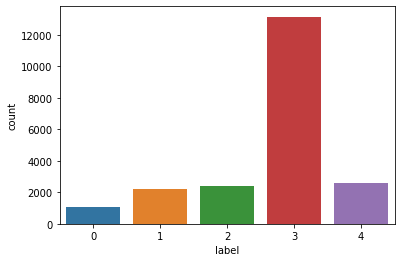

In [25]:
# Data distribution of whole set

labels=df.iloc[:,1]
lab_unique=labels.unique()
sns.countplot(labels)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


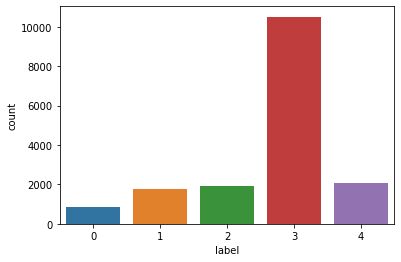

In [26]:
# training data distribution

labels=df1.iloc[:,1]
lab_unique=labels.unique()
sns.countplot(labels)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


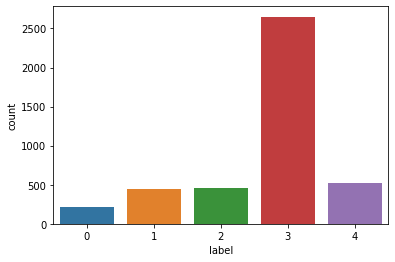

In [27]:
# testing data distribution

labels=df2.iloc[:,1]
lab_unique=labels.unique()
sns.countplot(labels)
plt.show()

# Data Generator

In [28]:
H,W=600,800
batch_size=8

In [29]:
# make both index to class and class to index dictionary

cls_map= {}
for k,v in data.items():
  k=int(k)
  cls_map[k]=v

rev_cls_map = {v: k for k, v in cls_map.items()}

cls_map, rev_cls_map

({0: 'Cassava Bacterial Blight (CBB)',
  1: 'Cassava Brown Streak Disease (CBSD)',
  2: 'Cassava Green Mottle (CGM)',
  3: 'Cassava Mosaic Disease (CMD)',
  4: 'Healthy'},
 {'Cassava Bacterial Blight (CBB)': 0,
  'Cassava Brown Streak Disease (CBSD)': 1,
  'Cassava Green Mottle (CGM)': 2,
  'Cassava Mosaic Disease (CMD)': 3,
  'Healthy': 4})

In [30]:
# Dataset class 

class dataset(Dataset):
    def __init__(self, H, W, im_fol , df,  rev_cls_map, transform=None):
        self.H, self.W= H, W
        self.im_fol = im_fol
        self.transform = transform
        self.df = df
        self.rev_cls_map=rev_cls_map
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        label = torch.tensor(self.df.loc[index, 'label'])
        name=self.df.loc[index, 'image_id']

        path = os.path.join(self.im_fol, name)
        image = Image.open(path)
        image = np.array( image.resize((W,H)) )/255

        if self.transform is not None:
            image = self.transform(image)

        image=image.to(dtype=torch.float)
        # labels=labels.to(dtype=torch.float)

        image=image.cuda()
        label=label.cuda()            

        return image, label


In [31]:
transform = transforms.Compose( [transforms.ToTensor()] )

train_dataset = dataset(H, W, "/content/data/train_images", df1, rev_cls_map, transform)
val_dataset =  dataset(H, W, "/content/data/train_images", df2, rev_cls_map, transform)

In [32]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False )

# Model Definition

In [33]:
class Net(nn.Module):
    def __init__(self, dropout=0.5):
        super(Net, self).__init__()
        # bb_model=torchvision.models.wide_resnet50_2(pretrained=True, progress=True)
        bb_model=torchvision.models.resnext50_32x4d(pretrained=True, progress=True)
        # bb_model=torchvision.models.resnext101_32x8d(pretrained=True, progress=True)
        self.backbone=torch.nn.Sequential(*(list(bb_model.children())[:-1]))

        self.dp1 = nn.Dropout(dropout)
        self.dp2 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(2048, 512 )
        self.fc2 = nn.Linear(512, 512)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)

        self.fc3 = nn.Linear(512, 5)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x=self.backbone(x)
        x=nn.Flatten()(x)

        x=self.dp1( F.relu( self.bn1( self.fc1(x) ) ))
        x=self.dp2( F.relu( self.bn2( self.fc2(x) ) ))
        x=self.fc3(x)
        x=self.softmax(x)

        return x


# Auxiliary functions 

In [34]:
# for model evaluation on testing data
def val_model(model, loss_fn, val_loader):
  val_loss=0
  total=0
  correct=0
  with torch.no_grad():
    for data, labels in val_loader:
      out = model(data)
      loss = loss_fn(out, labels)
      val_loss += loss.item()

      _, predicted = torch.max(out, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())

  acc=correct / total

  return val_loss/len(val_loader), acc


# function to get current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# function to log epoch results in a file    
def log_tensorboard(tb, epoch, record, validation=False):
  train_loss=record[0]
  train_acc=record[1]
  lr=record[2]
  val_loss=None
  val_acc=None

  tb.add_scalar("Train Loss", train_loss, epoch); tb.flush()
  tb.add_scalar("Train Accuracy", train_acc, epoch); tb.flush()
  tb.add_scalar("LR", lr, epoch); tb.flush()

  if validation:
    if len(record)==5:
      val_loss=record[3]
      val_acc=record[4]

    tb.add_scalar("Val Loss", val_loss, epoch); tb.flush()
    tb.add_scalar("Val Accuracy", val_acc, epoch); tb.flush()
      

In [35]:
# function to train model

def train_model(model, optimizer, total_epochs, 
                train_loader, loss_fn, model_folder, log_dir,
                validation=False, val_loader=None):
  
  train_loss=[]
  val_loss=[]
  train_acc=[]
  val_acc=[]
  lr=[]

  log_writer = SummaryWriter(log_dir)

  model.train()
  for epoch in range(1,total_epochs+1):    
    # Training progress bar
    kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch-1, num_epochs=total_epochs, 
                      width=40, always_stateful=True)    
    total_loss=0
    total=0
    correct=0

    # Train model
    for i,(data, labels) in enumerate(train_loader):
      out = model(data)
      loss = loss_fn(out, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      _, predicted = torch.max(out, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
      acc=correct/total

      closs=loss.item()
      tot=labels.shape[0]
      cor=int((predicted == labels).sum())
      tac=cor/tot

      kbar.update(i, values=[("loss", total_loss/(i+1)), ("acc", acc)])

    tloss=total_loss/len(train_loader)
    tacc=correct/total
    train_loss.append( tloss )
    train_acc.append( tacc )

    # Validate data
    if validation:
      vloss, vacc=val_model(model, loss_fn, val_loader)
      val_loss.append(vloss)
      val_acc.append(vacc)      
      kbar.add(1, values=[("val_loss", vloss), ("val_acc", vacc)])
    
    curr_lr=get_lr(optimizer)
    lr.append(curr_lr)

    # Save model
    model_path=os.path.join(model_folder, "model_{:02d}.pt".format(epoch))
    torch.save(model.state_dict(), model_path)

    # Tensorboard logging
    epoch_record=[tloss, tacc, curr_lr]
    if validation:
      epoch_record+=[vloss, vacc]
    log_tensorboard(log_writer, epoch, epoch_record, validation)

  log_writer.close()
  
  # Record metrics in an object
  history={}
  history['loss']=train_loss
  history['val_loss']=val_loss
  history['acc']=train_acc
  history['val_acc']=val_acc
  history['lr']=lr

  return history


In [36]:
# function to train model using scheduler

def train_model_by_scheduler(model, optimizer, scheduler, total_epochs, 
                train_loader, loss_fn, model_folder, log_dir,
                validation=False, val_loader=None):
  
  train_loss=[]
  val_loss=[]
  train_acc=[]
  val_acc=[]
  lr=[]

  log_writer = SummaryWriter(log_dir)

  model.train()
  for epoch in range(1,total_epochs+1):    
    # Training progress bar
    kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch-1, num_epochs=total_epochs, 
                      width=40, always_stateful=True)    
    total_loss=0
    total=0
    correct=0

    # Train model
    for i,(data, labels) in enumerate(train_loader):
      out = model(data)
      loss = loss_fn(out, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()
      total_loss += loss.item()

      _, predicted = torch.max(out, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
      acc=correct/total

      closs=loss.item()
      tot=labels.shape[0]
      cor=int((predicted == labels).sum())
      tac=cor/tot

      kbar.update(i, values=[("loss", total_loss/(i+1)), ("acc", acc)])

    tloss=total_loss/len(train_loader)
    tacc=correct/total
    train_loss.append( tloss )
    train_acc.append( tacc )

    # Validate data
    if validation:
      vloss, vacc=val_model(model, loss_fn, val_loader)
      val_loss.append(vloss)
      val_acc.append(vacc)      
      kbar.add(1, values=[("val_loss", vloss), ("val_acc", vacc)])
    
    curr_lr=get_lr(optimizer)
    lr.append(curr_lr)

    # Save model
    model_path=os.path.join(model_folder, "model_{:02d}.pt".format(epoch))
    torch.save(model.state_dict(), model_path)

    # Tensorboard logging
    epoch_record=[tloss, tacc, curr_lr]
    if validation:
      epoch_record+=[vloss, vacc]
    log_tensorboard(log_writer, epoch, epoch_record, validation)

  log_writer.close()

  # Record metrics in an object
  history={}
  history['loss']=train_loss
  history['val_loss']=val_loss
  history['acc']=train_acc
  history['val_acc']=val_acc
  history['lr']=lr

  return history


In [37]:
# function to retrain model

def retrain_model_by_scheduler(model, optimizer, scheduler, total_epochs, 
                train_loader, loss_fn, model_folder, log_dir, 
                initial_epoch=0, pre_trained_model=None,
                validation=False, val_loader=None):
  
  train_loss=[]
  val_loss=[]
  train_acc=[]
  val_acc=[]
  lr=[]

  log_writer = SummaryWriter(log_dir)

  if pre_trained_model:
    model.load_state_dict(torch.load(pre_trained_model))
  model.train()
  for epoch in range(1,total_epochs+1):    
    # Training progress bar
    kbar = pkbar.Kbar(target=len(train_loader), epoch=initial_epoch + epoch-1, num_epochs=total_epochs, 
                      width=40, always_stateful=True)    
    total_loss=0
    total=0
    correct=0

    # Train model
    for i,(data, labels) in enumerate(train_loader):
      out = model(data)
      loss = loss_fn(out, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()
      total_loss += loss.item()

      _, predicted = torch.max(out, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
      acc=correct/total

      closs=loss.item()
      tot=labels.shape[0]
      cor=int((predicted == labels).sum())
      tac=cor/tot

      kbar.update(i, values=[("loss", total_loss/(i+1)), ("acc", acc)])

    tloss=total_loss/len(train_loader)
    tacc=correct/total
    train_loss.append( tloss )
    train_acc.append( tacc )

    # Validate data
    if validation:
      vloss, vacc=val_model(model, loss_fn, val_loader)
      val_loss.append(vloss)
      val_acc.append(vacc)      
      kbar.add(1, values=[("val_loss", vloss), ("val_acc", vacc)])
    
    curr_lr=get_lr(optimizer)
    lr.append(curr_lr)

    # Save model
    model_path=os.path.join(model_folder, "model_{:02d}.pt".format(epoch + initial_epoch))
    torch.save(model.state_dict(), model_path)

    # Tensorboard logging
    epoch_record=[tloss, tacc, curr_lr]
    if validation:
      epoch_record+=[vloss, vacc]
    log_tensorboard(log_writer, epoch + initial_epoch, epoch_record, validation)

  log_writer.close()

  # Record metrics in an object
  history={}
  history['loss']=train_loss
  history['val_loss']=val_loss
  history['acc']=train_acc
  history['val_acc']=val_acc
  history['lr']=lr

  return history


In [38]:
# get cross entropy loss weights

uni_lab, count=np.unique(df1['label'].ravel(), return_counts=True)
for i in range(len(count)):
    print(uni_lab[i], count[i])

print("@"*20)
tot=877+1746+1931+10508+2055
print(N)
print("@"*20)

for c in count:
    v=-np.log10(c/tot)
    print(v)


weights= [1.2904, 0.9914, 0.9476, 0.2119, 0.9206]
class_weights = torch.FloatTensor(weights).cuda()

0 877
1 1746
2 1931
3 10508
4 2055
@@@@@@@@@@@@@@@@@@@@
21397
@@@@@@@@@@@@@@@@@@@@
1.2904280573014049
0.9913834112978945
0.9476453768880507
0.21190758655341274
0.9206158244553575


In [39]:
# location of weight files and log directory

weight_fol="/content/drive/MyDrive/cassava/weights/2"
logdir = os.path.join("/content/drive/MyDrive/cassava/logs/2", datetime.datetime.now().strftime("%d%m%Y-%H%M%S") )

# Model Creation

In [40]:
# Create model
net=Net()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [41]:
net

Net(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [42]:
summary(net, (3, H, W), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 400]           9,408
       BatchNorm2d-2         [-1, 64, 300, 400]             128
              ReLU-3         [-1, 64, 300, 400]               0
         MaxPool2d-4         [-1, 64, 150, 200]               0
            Conv2d-5        [-1, 128, 150, 200]           8,192
       BatchNorm2d-6        [-1, 128, 150, 200]             256
              ReLU-7        [-1, 128, 150, 200]               0
            Conv2d-8        [-1, 128, 150, 200]           4,608
       BatchNorm2d-9        [-1, 128, 150, 200]             256
             ReLU-10        [-1, 128, 150, 200]               0
           Conv2d-11        [-1, 256, 150, 200]          32,768
      BatchNorm2d-12        [-1, 256, 150, 200]             512
           Conv2d-13        [-1, 256, 150, 200]          16,384
      BatchNorm2d-14        [-1, 256, 1

# Train

In [44]:
net=net.cuda()

In [45]:
# model training attributes

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=1E-3)
scheduler = MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)

<b>Since because colab session dies often, there has been provision to retrain model from last epoch.
The following notebook shows the largest training session in colab </b>

In [46]:
# re-training parameters

initial_epoch=5
total_epochs=20
pre_trained_model="/content/model_05.pt"

In [ ]:
history=retrain_model_by_scheduler(net, optimizer, scheduler, total_epochs, 
                                 train_loader, loss_fn, weight_fol, logdir, 
                                 initial_epoch=initial_epoch, pre_trained_model=pre_trained_model, 
                                 validation=True, val_loader=val_loader)


Epoch: 6/20
2139/2139 [========================================] - 3132s 1s/step - loss: 1.3898 - acc: 0.6746 - val_loss: 1.2936 - val_acc: 0.7224
Epoch: 7/20
2139/2139 [========================================] - 3100s 1s/step - loss: 1.2490 - acc: 0.7459 - val_loss: 1.2494 - val_acc: 0.7360
Epoch: 8/20
2139/2139 [========================================] - 3101s 1s/step - loss: 1.2216 - acc: 0.7747 - val_loss: 1.2260 - val_acc: 0.7811
Epoch: 9/20
2139/2139 [========================================] - 3108s 1s/step - loss: 1.2042 - acc: 0.7885 - val_loss: 1.2071 - val_acc: 0.7848
Epoch: 10/20
2139/2139 [========================================] - 3104s 1s/step - loss: 1.1921 - acc: 0.7987 - val_loss: 1.1986 - val_acc: 0.7960
Epoch: 11/20
2139/2139 [========================================] - 3097s 1s/step - loss: 1.1788 - acc: 0.8140 - val_loss: 1.1933 - val_acc: 0.7979
Epoch: 12/20
2139/2139 [========================================] - 3055s 1s/step - loss: 1.1535 - acc: 0.8274 - val